<a href="https://colab.research.google.com/github/DonaldTurton/AT2_Advanced_Data_Algorithms/blob/master/AT2_GetData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Predicting Energy Prices

In [0]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt #Data Visualization
import seaborn as sns #Correlation plot
from google.colab import files

# Libraries for XGBOOST
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer


In [14]:
# Read csv
url = 'https://raw.githubusercontent.com/DonaldTurton/AT2_Advanced_Data_Algorithms/master/adaa_data.csv'
data = pd.read_csv(url)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,6912.25,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6745.63,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6466.06,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6279.80,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6177.31,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [15]:
# LAGG Total Demand by 30 mins 
data['TOTALDEMAND'] = data['TOTALDEMAND'].shift(1)
data.head()

,Year.x,Month,Day,TOTALDEMAND,RRP,date_keep,time_keep,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,day_of_week,segment_30min,index
0,2018,1,1,NaN,91.86,2018/01/01,00:30:00,31.0,20.8,28.3,0.0,1,0.000,0.0000,0.000,0.000,1,1,Monday,2,1
1,2018,1,1,6912.25,88.83,2018/01/01,01:00:00,31.0,20.8,28.3,0.0,1,NaN,0.0000,NaN,0.000,1,1,Monday,3,2
2,2018,1,1,6745.63,73.62,2018/01/01,01:30:00,31.0,20.8,28.3,0.0,1,90.345,0.0000,6828.940,0.000,1,1,Monday,4,3
3,2018,1,1,6466.06,71.49,2018/01/01,02:00:00,31.0,20.8,28.3,0.0,1,81.225,81.4500,6605.845,6600.935,1,1,Monday,5,4
4,2018,1,1,6279.80,69.27,2018/01/01,02:30:00,31.0,20.8,28.3,0.0,1,72.555,75.8025,6372.930,6417.200,1,1,Monday,6,5


In [16]:
# Exploring the data set
data.shape   


(28080, 21)

In [0]:
### WE ARE NOW USING ALL THE VARIABLES
# Data Set Selection  
#data = data.loc[:, ["RRP", "TOTALDEMAND", "Month", "Day", "time", "Maximum.temperature..Degree.C.", "Minimum.temperature..Degree.C.", "Rainfall.amount..millimetres.", "Daily.global.solar.exposure..MJ.m.m."]]
#month, day, demand, maxtemp, mintemp, rainfall, solarexpo, timeofday
#data.head()


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28080 entries, 0 to 28079
Data columns (total 21 columns):
Year.x                                  28080 non-null int64
Month                                   28080 non-null int64
Day                                     28080 non-null int64
TOTALDEMAND                             28079 non-null float64
RRP                                     28080 non-null float64
date_keep                               28080 non-null object
time_keep                               28080 non-null object
Daily.global.solar.exposure..MJ.m.m.    28080 non-null float64
Minimum.temperature..Degree.C.          28080 non-null float64
Maximum.temperature..Degree.C.          28080 non-null float64
Rainfall.amount..millimetres.           28080 non-null float64
Season                                  28080 non-null int64
price_mov_avg_1hr                       28079 non-null float64
price_mov_avg_2hr                       28080 non-null float64
demand_mov_avg_1hr 

In [18]:
data.describe()

#MAX PRICE 4631??

,Year.x,Month,Day,TOTALDEMAND,RRP,Daily.global.solar.exposure..MJ.m.m.,Minimum.temperature..Degree.C.,Maximum.temperature..Degree.C.,Rainfall.amount..millimetres.,Season,price_mov_avg_1hr,price_mov_avg_2hr,demand_mov_avg_1hr,demand_mov_avg_2hr,segment_day,week_of_year,segment_30min,index
count,28080.000000,28080.000000,28080.000000,28079.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000,28079.000000,28080.000000,28079.000000,28080.000000,28080.000000,28080.000000,28080.000000,28080.000000
mean,2018.376104,5.637856,15.545584,8081.261910,84.282953,16.133415,14.858526,23.990242,2.190085,2.331695,84.277452,84.271783,8081.003649,8080.485022,2.458333,22.643839,24.500000,14040.500000
std,0.484415,3.223593,8.825677,1236.576367,58.744794,6.895621,5.044146,5.425505,6.981044,1.020859,51.098684,44.997070,1222.512947,1212.795148,1.153969,14.001739,13.853646,8106.142116
min,2018.000000,1.000000,1.000000,5552.230000,2.980000,1.700000,4.200000,13.800000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,2018.000000,3.000000,8.000000,7187.235000,62.300000,11.100000,10.400000,19.800000,0.000000,1.000000,62.460000,62.725000,7196.875000,7205.216875,1.000000,11.000000,12.750000,7020.750000
50%,2018.000000,5.000000,15.000000,7996.030000,74.920000,14.400000,15.300000,23.400000,0.000000,2.000000,75.465000,76.061250,7997.705000,7996.440000,3.000000,21.000000,24.500000,14040.500000
75%,2019.000000,8.000000,23.000000,8789.740000,94.802500,20.700000,19.200000,27.900000,0.400000,3.000000,95.032500,95.370000,8786.410000,8779.598750,3.000000,32.000000,36.250000,21060.250000
max,2019.000000,12.000000,31.000000,13700.900000,4631.980000,32.100000,23.800000,43.700000,56.600000,4.000000,3478.520000,2372.550000,13669.780000,13583.927500,4.000000,52.000000,48.000000,28080.000000


In [0]:
### ONE HOT-ENCONDING for TYPE OBJECTS or tranform to numeric??? or dates???

In [19]:
#Find Null values 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       1
price_mov_avg_2hr                       0
demand_mov_avg_1hr                      1
demand_mov_avg_2hr                      0
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
dtype: int64

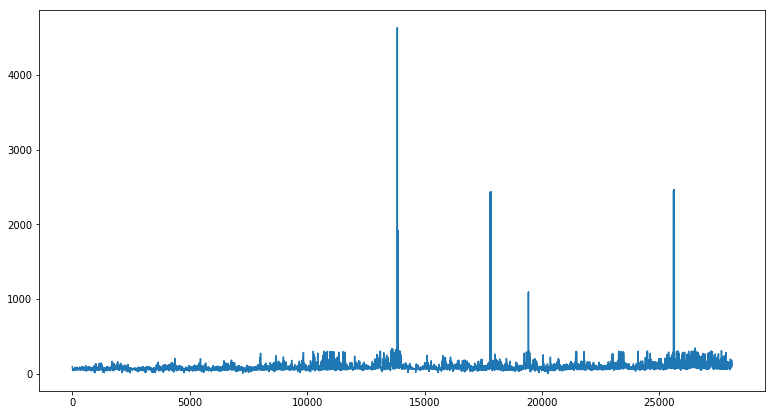

In [20]:
#Plot trend
Price = data["RRP"].values
plt.figure(figsize=(13,7))
plt.plot(Price)
plt.show()

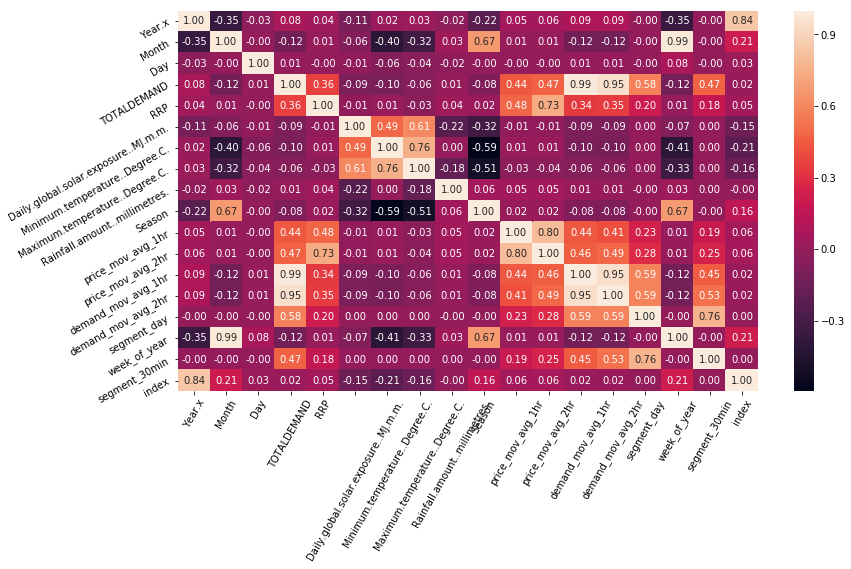

In [21]:
corr = data.corr()
plt.figure(figsize=(13,7))
a = sns.heatmap(corr, annot=True, fmt='.2f')
rotx = a.set_xticklabels(a.get_xticklabels(), rotation=60) 
roty = a.set_yticklabels(a.get_yticklabels(), rotation=30) 
plt.show()

# XG Boost (First Attempt)

In [0]:
#Drops Na  NON NA's
#data.dropna(axis=0, subset=['RRP'], inplace=True)

In [22]:
#Chek 
data.isnull().sum()

Year.x                                  0
Month                                   0
Day                                     0
TOTALDEMAND                             1
RRP                                     0
date_keep                               0
time_keep                               0
Daily.global.solar.exposure..MJ.m.m.    0
Minimum.temperature..Degree.C.          0
Maximum.temperature..Degree.C.          0
Rainfall.amount..millimetres.           0
Season                                  0
price_mov_avg_1hr                       1
price_mov_avg_2hr                       0
demand_mov_avg_1hr                      1
demand_mov_avg_2hr                      0
segment_day                             0
week_of_year                            0
day_of_week                             0
segment_30min                           0
index                                   0
dtype: int64

In [0]:
# DATA PARTITIONING  TIME SERIES


In [0]:
# Objective variable selection
y = data.RRP
X = data.drop(['RRP'], axis=1).select_dtypes(exclude=['object'])


In [24]:
# Data partition
train_X, test_X, train_y, test_y = train_test_split(X.as_matrix(), y.as_matrix(), test_size=0.25)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [25]:
#Check data set partitioning 
train_X.shape, train_y.shape

((21060, 17), (21060,))

In [26]:
#Imputer FOR COMPLEATING MISSING VALUES 
my_imputer = Imputer()
train_X = my_imputer.fit_transform(train_X)
test_X = my_imputer.transform(test_X)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [27]:
# Build model
import xgboost
from xgboost import XGBRegressor

my_model = XGBRegressor(seed=123)
# Add silent=True to avoid printing out updates with each cycle
my_model.fit(train_X, train_y, verbose=True)

[05:47:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
predictions = my_model.predict(test_X)

##Model Error 

In [31]:
#MAE
from sklearn.metrics import mean_absolute_error
print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))

Mean Absolute Error : 9.711843669641391


In [29]:
#MSE
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(predictions,test_y)
print("Mean Squared Error : " + str( np.sqrt(mse)))

Mean Squared Error : 53.81854968589748


In [30]:
#RMSE
rmse = np.sqrt(mean_squared_error(predictions,test_y))
print("RMSE: " + str(rmse))

RMSE: 53.81854968589748


# Hyper Parameter Tunning

## 1st

In [32]:
# Early Stoppig Round And Learning rate
XGB_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, seed=123)
XGB_model.fit(train_X, train_y, early_stopping_rounds=50, 
             eval_set=[(test_X, test_y)], verbose=False)

[05:48:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [0]:
# make predictions
XGB_predictions = XGB_model.predict(test_X)

In [34]:
XGB_mse = mean_squared_error(XGB_predictions,test_y)
print("Mean Squared Error : " + str( np.sqrt(XGB_mse)))

Mean Squared Error : 53.75737860235285


## 2nd attempt 

In [285]:
# Optimized Data Structure
data_dmatrix = xgboost.DMatrix(data=X,label=y)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [298]:
xg_reg = xgboost.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 3, alpha = 10, n_estimators = 10000, seed=123)

xg_reg.fit(train_X, train_y, early_stopping_rounds=50, 
             eval_set=[(test_X, test_y)], verbose=False)

[05:18:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=10000,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             silent=None, subsample=1, verbosity=1)

In [0]:
preds = xg_reg.predict(test_X)

In [300]:
xg_regrmse = np.sqrt(mean_squared_error(test_y, preds))
print("RMSE: %f" % (xg_regrmse))

RMSE: 48.418827


## k-fold Cross Validation

In [0]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.05, 'early_stopping_rounds':50,
                'max_depth': 3, 'alpha': 10, 'seed':123}


In [290]:

cv_results = xgboost.cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=100,early_stopping_rounds=50,metrics="rmse", as_pandas=True, seed=123)

[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:03:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [291]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,98.520464,1.527195,97.822008,12.836984
1,94.686671,1.502474,94.191867,13.152139
2,91.151806,1.530445,90.803474,13.528141
3,87.846453,1.513940,87.619987,13.949666
4,84.646154,1.452165,84.569990,14.279198


In [292]:
print((cv_results["test-rmse-mean"]).tail(1))

99    40.573419
Name: test-rmse-mean, dtype: float64


## Results Visualization

### Tree 

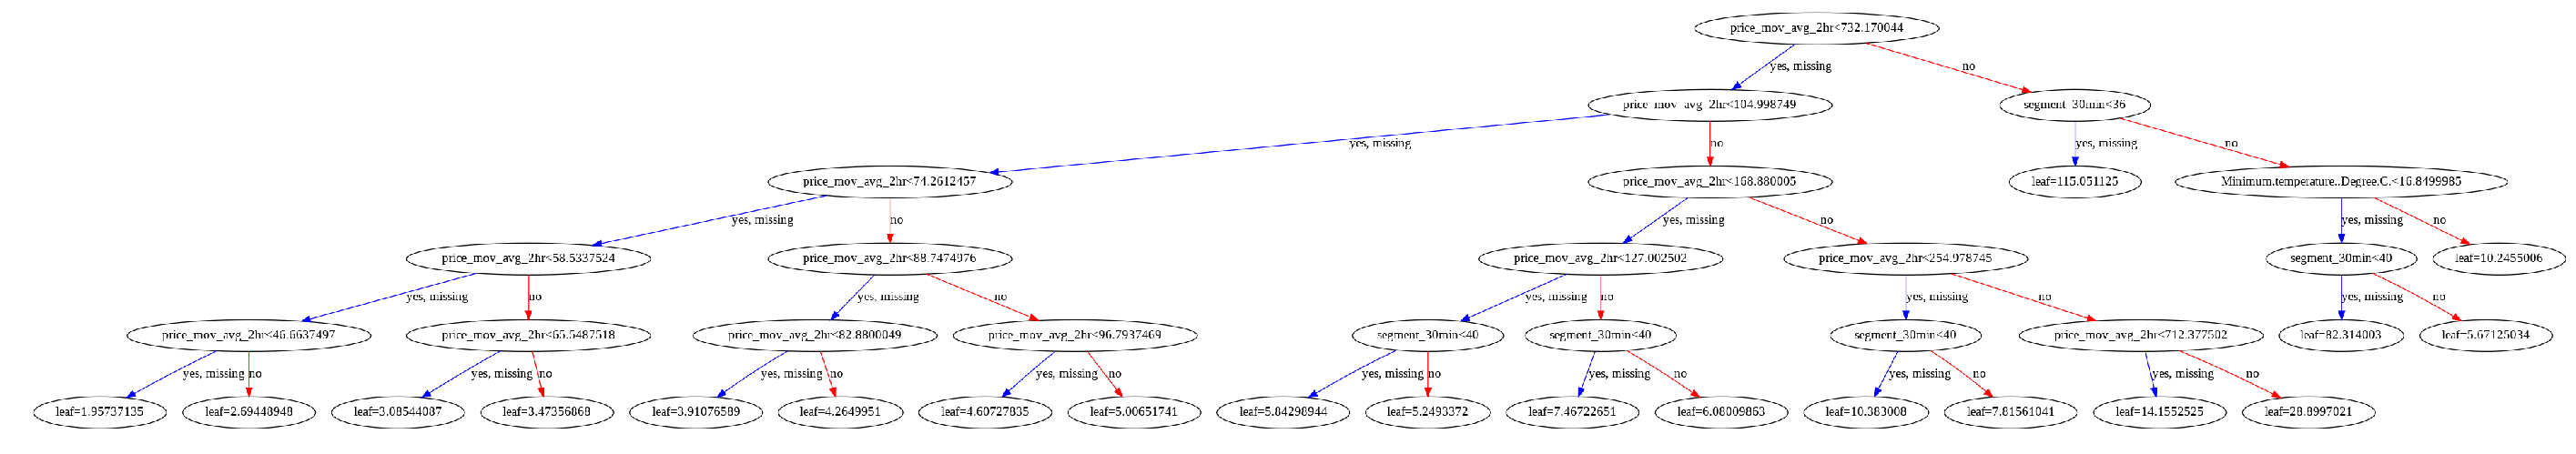

In [215]:
#Plot tree
xgboost.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 20]
plt.show()

### Feauture Impotance

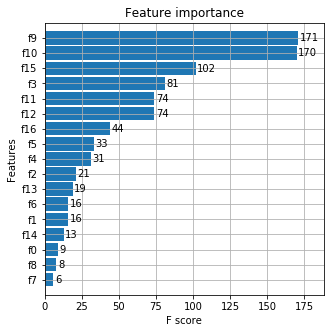

In [294]:
xgboost.plot_importance(xg_reg, height=0.9)